In [17]:
# Gross code to allow for importing from parent directory
import os, sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))

### Imports

In [18]:
import torch
import einops

from transformer_lens import HookedTransformer
from load_data import get_prompts_t
from plotting import ntensor_to_long
from jamesd_utils import reinforcement_ratio, projection_value

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


# Global settings and variables
torch.set_grad_enabled(False)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

In [19]:
prompts = get_prompts_t()
# prompts = get_prompts_t(n_text_prompts=160, n_code_prompts=40)

# Throws a warning if there is a non-unique prompt
if not (torch.unique(prompts, dim=0).shape == prompts.shape):
    print("WARNING: at least 1 prompt is not unique")

Loading 80 prompts from c4-tokenized-2b...


  0%|          | 0/80 [00:00<?, ?it/s]

Loading 20 prompts from code-tokenized...


  0%|          | 0/20 [00:00<?, ?it/s]

In [20]:
#Transformer Lens model names:
# https://github.com/neelnanda-io/TransformerLens/blob/3cd943628b5c415585c8ef100f65989f6adc7f75/transformer_lens/loading_from_pretrained.py#L127

model_name = "gelu-4l"
model = HookedTransformer.from_pretrained(model_name, device=device)
model.cfg.use_attn_result = True

Loaded pretrained model gelu-4l into HookedTransformer


In [21]:
# Generate names of residual stream components
hook_names = [
    "attn.hook_result",
    "mlp_out",
]

In [22]:
# Run a forward pass and cache selected activations
_, cache = model.run_with_cache(
    prompts,
    names_filter=lambda name: any(hook_name in name for hook_name in hook_names),
    device=device,
)

In [36]:
# Create a tensor of nodes
nodes_list = []
for l in range(model.cfg.n_layers):
    heads = einops.rearrange(
        cache[f'blocks.{l}.attn.hook_result'],
        "batch pos head d_model -> head batch pos d_model"
    )
    mlp = einops.rearrange(
        cache[f'blocks.{l}.hook_mlp_out'],
        "batch pos d_model -> 1 batch pos d_model"
    )
    nodes_list.extend([heads, mlp])

all_nodes = torch.cat(nodes_list, dim=0)  # (n_nodes, batch, pos, d_model)

# Create node names
node_names = []
for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        node_names.append(f"H{l}.{h}")
    node_names.append(f"MLP{l}")

node_names[:model.cfg.n_heads+1]

['H0.0', 'H0.1', 'H0.2', 'H0.3', 'H0.4', 'H0.5', 'H0.6', 'H0.7', 'MLP0']

In [37]:
def get_node_from_cache(cache, node_name: str):
    if node_name.startswith("H"):
        layer, head = node_name[1:].split(".")
        layer = int(layer)
        head = int(head)
        return cache[f'blocks.{layer}.attn.hook_result'][:, :, head, :].unsqueeze(0)
    elif node_name.startswith("MLP"):
        layer = int(node_name[3:])
        return cache[f'blocks.{layer}.hook_mlp_out'].unsqueeze(0)

In [63]:
# Get the writer node's tensor from a given node name
writer_name = "H0.4"
writer_node = get_node_from_cache(cache, writer_name)

In [64]:
# Check for shape alignment
print(all_nodes.shape)
print(writer_node.shape)

torch.Size([36, 100, 1024, 512])
torch.Size([1, 100, 1024, 512])


In [65]:
# Calculate reinforcement ratios off all nodes projected onto the writer node
reinf_ratios = reinforcement_ratio(all_nodes, writer_node)  # shape: (resid node batch pos)

In [66]:
# Get RRs into a long format df
df = ntensor_to_long(
    reinf_ratios,
    value_name="reinforcement_ratio",
    dim_names=["node", "batch", "pos"],
)

layers, comps = divmod(df.node, model.cfg.n_heads + 1)
df["layer"] = layers
df["comp"] = comps
df["node_name"] = df.node.map(lambda x: node_names[x])

In [67]:
# Create node names for x ticks
node_names_without = node_names.copy()
node_names_without.remove(writer_name)

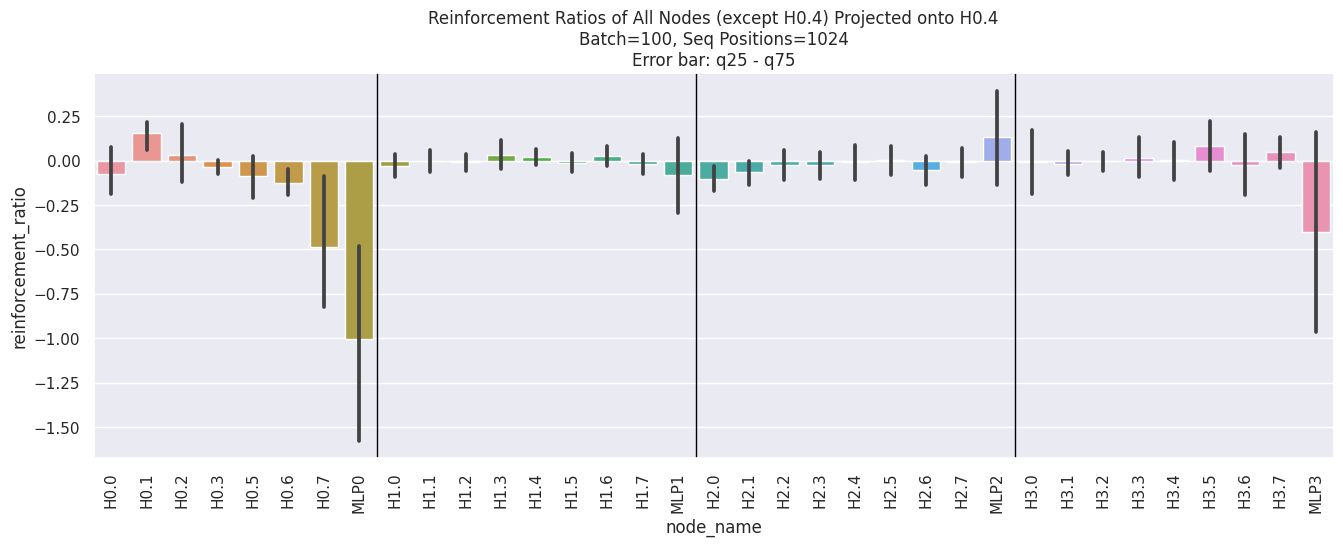

In [68]:
# Create figure
fig, ax = plt.subplots(figsize=(16, 5))

sns.barplot(
    data=df.query("node_name != @writer_name"),
    x="node_name",
    y="reinforcement_ratio",
    errorbar=("pi", 75),
    order=node_names_without,
    ax=ax,
)

# Add vlines to separate layers
for l in [node_names_without.index(f"H{i}.0") for i in range(1, model.cfg.n_layers)]:
    ax.axvline(l - 0.5, color="black", linewidth=1)

# Rotate x-axis labels
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax.set_title(
    f"Reinforcement Ratios of All Nodes (except {writer_name}) Projected onto {writer_name}\n"
    f"Batch={reinf_ratios.shape[1]}, Seq Positions={reinf_ratios.shape[2]}\n"
    f"Error bar: q25 - q75"
);